# Pairs Trading Strategy Design & Backtesting

## CQF Final Project


## Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import yfinance as yf
import statsmodels.api as sm
import itertools
from statsmodels.tsa.stattools import coint, adfuller
import seaborn as sns
import backtrader as bt
import backtrader.analyzers as btanalyzers
import warnings
from prettytable import PrettyTable
import pyfolio as pf
%matplotlib inline

d:\Anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


## Pairs Selection

### Intuition
In the realm of pairs trading, the selection of compatible stocks is crucial for harnessing market efficiencies and mitigating risks. The selection of **Coca-Cola (KO)**, **Pepsi (PEP)**, and **Costco (COST)** as trading pairs is informed by their shared positioning within the Consumer Staples sector, specifically under the **XLP** index. Their similar index weights in this sector are a key factor in this choice. This commonality in market positioning is crucial for pairs trading, which thrives on the stationary difference between paired stocks. Coca-Cola and Pepsi, being leading players in the beverage industry, and Costco, a major retail player, demonstrate comparable market behaviors and consumer interactions due to their sectoral alignment. This similarity in their market dynamics and consumer base, underpinned by their balanced representation in the XLP index, makes them a strategic choice for exploiting potential price relationships in pairs trading. Their aligned performance trends, responding similarly to sector-specific market stimuli, offer a fertile ground for identifying and capitalizing on subtle price discrepancies while maintaining a risk-adjusted approach.

### Fundamental Characteristic
The RBICS Revenue profiles of **Coca-Cola (KO)**, **Pepsi (PEP)**, and **Costco (COST)** reveal a compelling alignment for pairs trading. Coca-Cola and Pepsi both show a 100% concentration in the Food and Beverage Production sector, while Costco is entirely focused on General Merchandise Retail. What stands out is that all three companies fall under the broader category of **Consumer Non-Cyclicals**, each with a **100%** commitment. This data highlights a unique blend of operational specialization within a shared overarching sector. Such a distinct yet cohesive revenue structure among these companies is vital for pairs trading. It indicates that while each company operates in different niches—beverage production for KO and PEP, and retail for COST—they are bound by similar market forces inherent to the Consumer Non-Cyclicals sector. This congruence in their sector-specific financial characteristics makes them ideal for a pairs trading strategy, aimed at leveraging nuances in stocks that are fundamentally similar yet distinct in their market niches.

<figure style="text-align: center;">
    <img src="./src_img/KO_RBICS_Rev.png" width="1000" height="130" alt="Description">
    <figcaption>Coca-Cola RBICS Revenue(Revenue Exposure by Sector / Industry)</figcaption>
</figure>

<figure style="text-align: center;">
    <img src="./src_img/PEP_RBICS_Rev.png" width="1000" height="320" alt="Description">
    <figcaption>Pepsi RBICS Revenue(Revenue Exposure by Sector / Industry)</figcaption>
</figure>

<figure style="text-align: center;">
    <img src="./src_img/COST_RBICS_Rev.png" width="1000" height="110" alt="Description">
    <figcaption>Costco RBICS Revenue(Revenue Exposure by Sector / Industry)</figcaption>
    <p>Data Source: FactSet</p>
</figure>

The financial profiles of **Coca-Cola (KO)**, **Pepsi (PEP)**, and **Costco (COST)** create an advantageous framework for pairs trading within the Consumer Staples sector. Coca-Cola and Pepsi, with similar beta values (0.50 and 0.51), and Costco with a slightly higher beta of 1.03, all maintain significant weights in the XLP index. Their large market capitalizations and robust financial metrics underscore their stability and investment appeal. This alignment in the Consumer Staples sector, combined with their distinct market niches, presents an ideal scenario for pairs trading, exploiting subtle differences in a fundamentally cohesive sector.

| Ticker | Name                  | Sector Weight(XLP) | Beta | Market Cap | P/E Ratio | P/B Ratio | Yield% |
| ------ | --------------------- | ---------- | ---- | ---------- | --------- | --------- | ----- |
| KO     | Coca-Cola Co          | 9.39%      | 0.50 | 259.88 B   | 24.23     | 9.87      | 3.06% |
| PEP    | PepsiCo Inc           | 9.24%      | 0.51 | 232.50 B   | 28.23     | 12.36     | 2.92% |
| COST   | Costco Wholesale Corp | 11.88%     | 1.03 | 293.61 B   | 45.12     | 11.23     | 0.60% |

## Data Preprocessing

I chose Yahoo Finance for data acquisition due to its status as a stable and free public data source. Its robust API is ideal for efficiently retrieving historical stock price information, essential for detailed financial analysis and trading strategies.

In [2]:
start_date = '2014-01-01'
end_date = '2024-01-01'

stocks = yf.Tickers('KO PEP COST XLP')
KO = stocks.tickers['KO'].history(start=start_date, end=end_date)['Close']
PEP = stocks.tickers['PEP'].history(start=start_date, end=end_date)['Close']
COST = stocks.tickers['COST'].history(start=start_date, end=end_date)['Close']
XLP = stocks.tickers['XLP'].history(start=start_date, end=end_date)['Close']
df = stocks.history(start=start_date, end=end_date)['Close']

[*********************100%%**********************]  4 of 4 completed


In [3]:
# Data Integrity Check
for i in [KO, PEP, COST, XLP]:
    print(i.isna().sum())
    print(len(i))
    print(i.index[0])
    print(i.index[-1])

print('DF Data Check')
print('NA Value Check')
for column in df.columns:
    na_count = df[column].isna().sum()
    print(f'{column}: {na_count}')
print('DF Shape:', df.shape)

0
2516
2014-01-02 00:00:00-05:00
2023-12-29 00:00:00-05:00
0
2516
2014-01-02 00:00:00-05:00
2023-12-29 00:00:00-05:00
0
2516
2014-01-02 00:00:00-05:00
2023-12-29 00:00:00-05:00
0
2516
2014-01-02 00:00:00-05:00
2023-12-29 00:00:00-05:00
DF Data Check
NA Value Check
COST: 0
KO: 0
PEP: 0
XLP: 0
DF Shape: (2516, 4)


In [4]:
# Stock Return
df['KO_Log_Return'] = np.log(df['KO'] / df['KO'].shift(1))
df['PEP_Log_Return'] = np.log(df['PEP'] / df['PEP'].shift(1))
df['COST_Log_Return'] = np.log(df['COST'] / df['COST'].shift(1))
df['XLP_Log_Return'] = np.log(df['XLP'] / df['XLP'].shift(1))

# Log Price
df['KO_Log_Price'] = np.log(df['KO'])
df['PEP_Log_Price'] = np.log(df['PEP'])
df['COST_Log_Price'] = np.log(df['COST'])
df['XLP_Log_Price'] = np.log(df['XLP'])

# Relative Price
df['KO_Relative'] = df['KO'] / df['KO'].iloc[0]
df['PEP_Relative'] = df['PEP'] / df['PEP'].iloc[0]
df['COST_Relative'] = df['COST'] / df['COST'].iloc[0]
df['XLP_Relative'] = df['XLP'] / df['XLP'].iloc[0]

## Exploratory Data Analysis

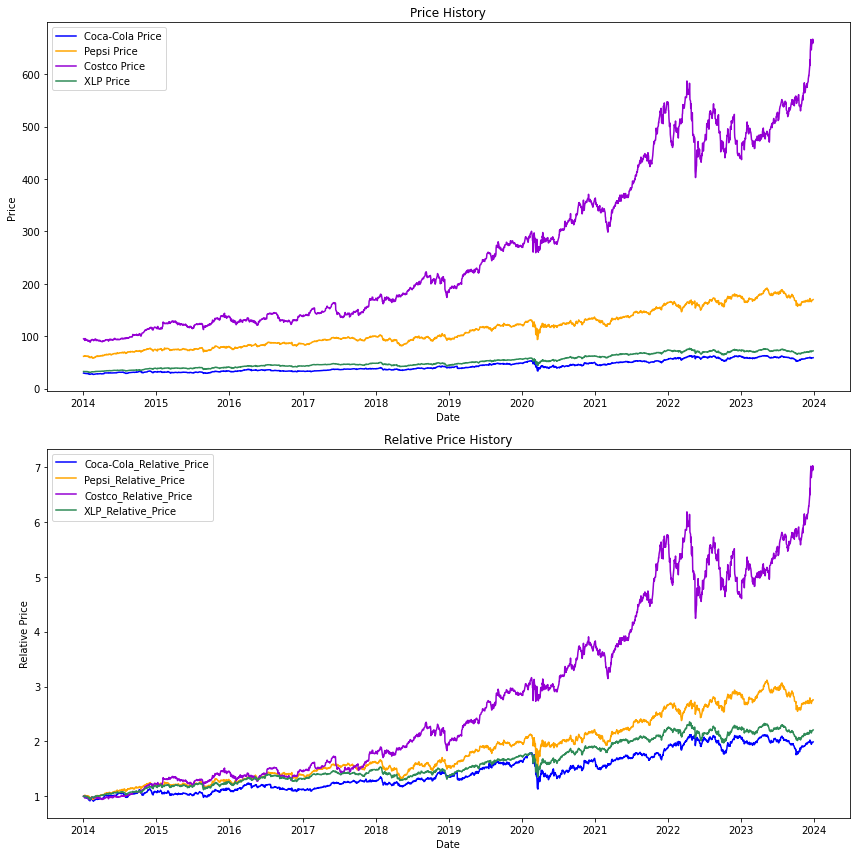

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

axes[0].plot(df.index, df['KO'], label="Coca-Cola Price", color='blue')
axes[0].plot(df.index, df['PEP'], label="Pepsi Price", color='orange')
axes[0].plot(df.index, df['COST'], label="Costco Price", color='darkviolet')
axes[0].plot(df.index, df['XLP'], label="XLP Price", color='seagreen')
axes[0].set_title("Price History")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Price")
axes[0].legend()

axes[1].plot(df.index, df['KO_Relative'], label="Coca-Cola_Relative_Price", color='blue')
axes[1].plot(df.index, df['PEP_Relative'], label="Pepsi_Relative_Price", color='orange')
axes[1].plot(df.index, df['COST_Relative'], label="Costco_Relative_Price", color='darkviolet')
axes[1].plot(df.index, df['XLP_Relative'], label="XLP_Relative_Price", color='seagreen')
axes[1].set_title("Relative Price History")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Relative Price")
axes[1].legend()

plt.tight_layout()
plt.show()

In [6]:
df.head()

,COST,KO,PEP,XLP,KO_Log_Return,PEP_Log_Return,COST_Log_Return,XLP_Log_Return,KO_Log_Price,PEP_Log_Price,COST_Log_Price,XLP_Log_Price,KO_Relative,PEP_Relative,COST_Relative,XLP_Relative
Date,,,,,,,,,,,,,,,,
2014-01-02,94.920311,29.601589,61.579594,32.607174,NaN,NaN,NaN,NaN,3.387828,4.120331,4.553038,3.484532,1.000000,1.000000,1.000000,1.000000
2014-01-03,94.501312,29.455994,61.684605,32.545723,-0.004931,0.001704,-0.004424,-0.001886,3.382897,4.122034,4.548614,3.482646,0.995081,1.001705,0.995586,0.998115
2014-01-06,93.784279,29.317659,61.714600,32.422817,-0.004707,0.000486,-0.007616,-0.003784,3.378190,4.122521,4.540997,3.478862,0.990408,1.002192,0.988032,0.994346
2014-01-07,93.349174,29.405016,62.614624,32.599487,0.002975,0.014478,-0.004650,0.005434,3.381165,4.136999,4.536347,3.484297,0.993359,1.016808,0.983448,0.999764
2014-01-08,91.890854,29.077415,62.434647,32.353683,-0.011203,-0.002879,-0.015746,-0.007569,3.369962,4.134120,4.520602,3.476728,0.982292,1.013885,0.968084,0.992226


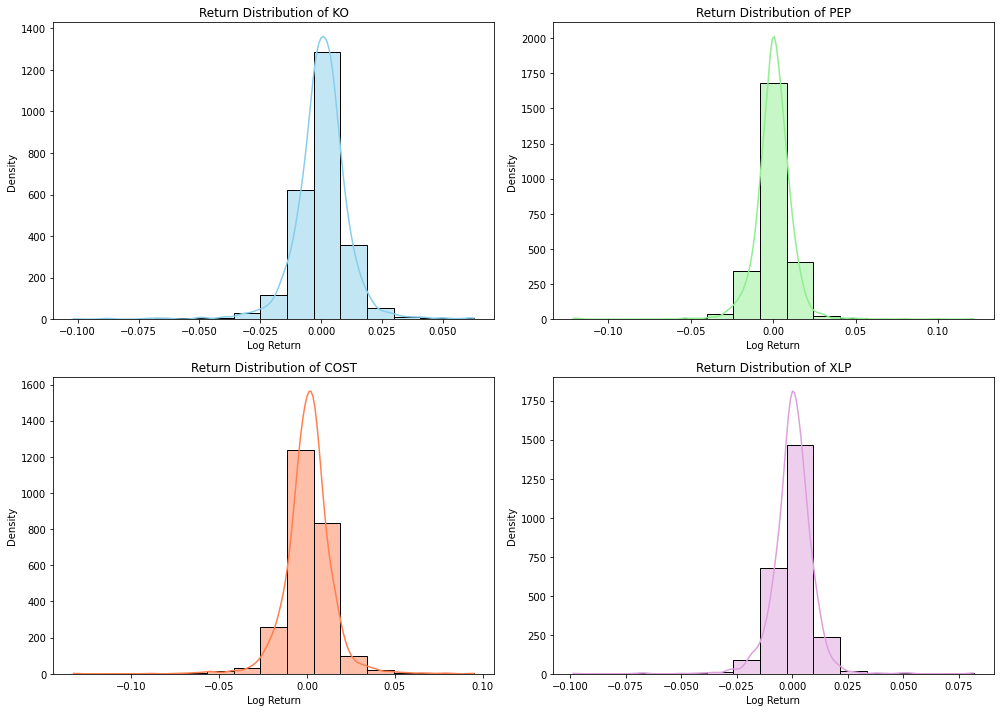

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = ['skyblue', 'lightgreen', 'coral', 'plum']

for i, column in enumerate(df.filter(like='_Log_Return')):
    ax = axes[i//2, i%2]
    sns.histplot(data=df, x=column, kde=True, bins=15, color=colors[i], ax=ax)
    comp_name = column.split('_')[0]
    ax.set_title(f'Return Distribution of {comp_name}')
    ax.set_xlabel('Log Return')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

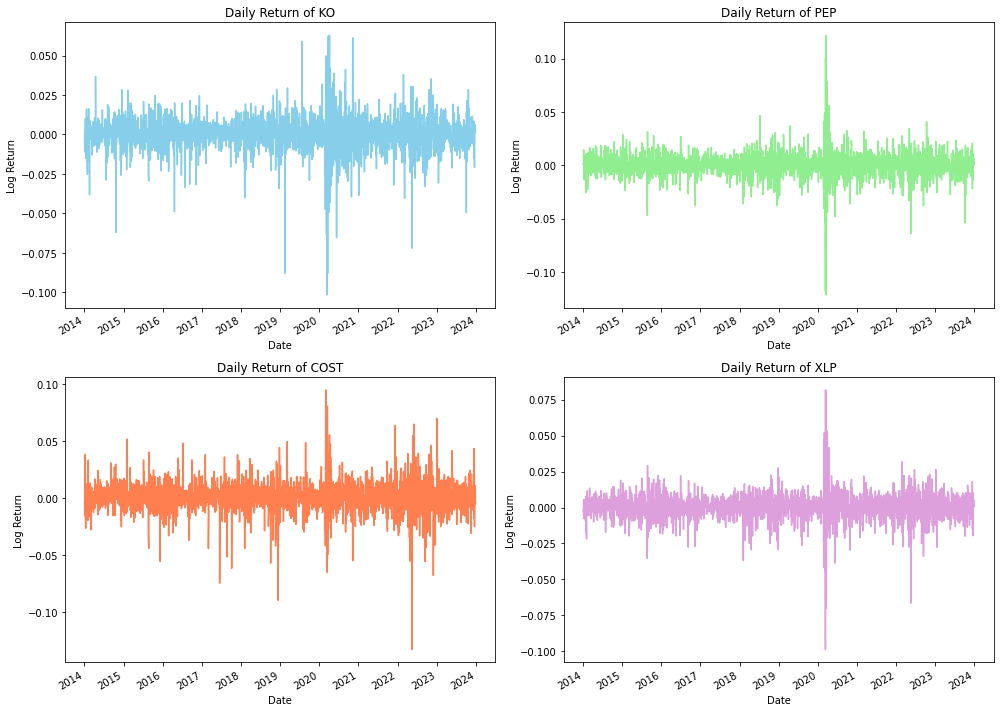

In [8]:
df_ret = df.filter(like='_Log_Return').dropna()
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = ['skyblue', 'lightgreen', 'coral', 'plum']

for i, column in enumerate(df_ret.columns):
    ax = axes[i // 2, i % 2]
    df_ret[column].plot(ax=ax, color=colors[i])
    comp_name = column.split('_')[0]
    ax.set_title(f'Daily Return of {comp_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')

plt.tight_layout()
plt.show()

## Engle-Granger Procedure for estimating cointegration

The Engle-Granger procedure is a **two-step** approach for analyzing the relationship between two time series variables.
 
In the first step, it assesses if there's a long-term equilibrium (cointegration) between the variables by regressing one on the other and testing the stationarity of the residuals using the Augmented Dickey-Fuller (ADF) test. Stationary residuals imply a stable, long-term relationship. The second step involves modeling short-term adjustments through an Error Correction Model (ECM), which links short-term changes in one variable to the other and the lagged error term representing deviations from the long-term equilibrium. This procedure helps in understanding both the long-term relationship and the short-term dynamics between two time series variables.

**Step 1**  
The Engle-Granger cointegration test is a widely recognized statistical procedure used for investigating the presence of a long-term equilibrium relationship between two time series datasets. This cointegration test involves a two-step process. 

First, a regression analysis is conducted where one time series is regressed against another, with the aim of capturing their potential long-term relationship. The second step, which is critical to the process, involves applying the **Augmented Dickey-Fuller (ADF) test** to the residuals resulting from this regression. It is important to note that in this implementation of the ADF test, **the trend component ($βt$ term) is not included**. This exclusion is crucial as the inclusion of a trend component in the ADF test can lead to false assumptions about the nature of the residual series. The absence of a trend component in the test helps ensure a more accurate assessment of the stationarity of the residuals. 

**Stationarity** of these **residuals** is a key indicator of **cointegration**, suggesting that the variables, though they may fluctuate in the short term, maintain a stable long-term relationship. 

$$ \text{Residuals: }\hat{e}_t = P^A_t - \beta_c P^B_t - \hat{\mu}_e$$

$$\text{ADF test: } \Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \delta \Delta y_{t-1} + \epsilon_t$$

$$ \text{Cointegrating vector: } \beta'_{\text{coint}} = [1, -\hat{\beta}_c]  \text{ Equilibrium level: } \mathbb{E}[\hat{\theta}_t] = \hat{\mu}_e$$

In [9]:
def engle_granger_coint_test(X, y):
    """Perform the Engle-Granger cointegration test."""
    # Step 1: regress on variable on the other
    x_name = X.name if isinstance(X, pd.Series) else 'X'
    y_name = y.name if isinstance(y, pd.Series) else 'y'
    pair_name = f'({y_name}, {x_name})'
    X = sm.add_constant(X)
    lm = sm.OLS(y, X).fit()
    # Step 2: obtain the residual
    res = lm.resid
    # Step 3: apply Augmented Dickey-Fuller test to residuals with one lag
    temp_df = pd.DataFrame({'residuals':res})
    temp_df['diff'] = temp_df['residuals'].diff()
    temp_df['res_lag1'] = temp_df['residuals'].shift(1)
    temp_df['diff_lag1'] = temp_df['diff'].shift(1)
    temp_df = temp_df.dropna()
    X1 = temp_df[['res_lag1', 'diff_lag1']]
    X1 = sm.add_constant(X1)
    y1 = temp_df['diff']
    lm1 = sm.OLS(y1, X1).fit()
    # Step 4: Confirm the significance of coefficient of lagged residual(gamma)
    t_value = lm1.tvalues['res_lag1']
    p_value = lm1.pvalues['res_lag1']
    test_result = 'Stationary' if p_value < 0.05 else 'Not Stationary'
    results_df = pd.DataFrame({
        'ADF Statistic': t_value,
        'p-value': p_value,
        'Test Result': test_result
    }, index=[pair_name])
    print('ADF test Results')
    print(results_df)
    print(lm1.summary())
    # Plot the residual series
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    res.plot(color='orange', linestyle='-', linewidth=1.5)
    plt.title(f'Residuals for {pair_name}', fontsize=16)
    return results_df, res

ADF test Results
            ADF Statistic   p-value Test Result
(KO, COST)      -3.557189  0.000382  Stationary
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     7.051
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           0.000884
Time:                        01:14:22   Log-Likelihood:                -1615.4
No. Observations:                2514   AIC:                             3237.
Df Residuals:                    2511   BIC:                             3254.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

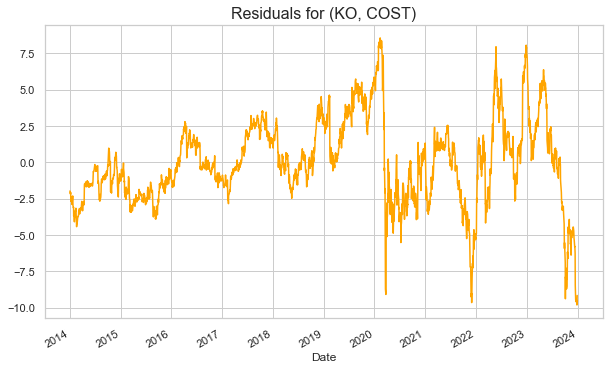

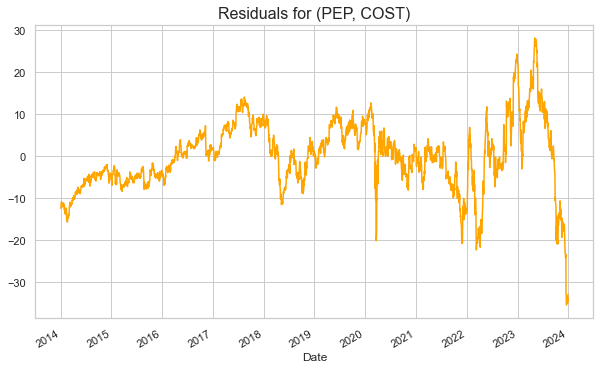

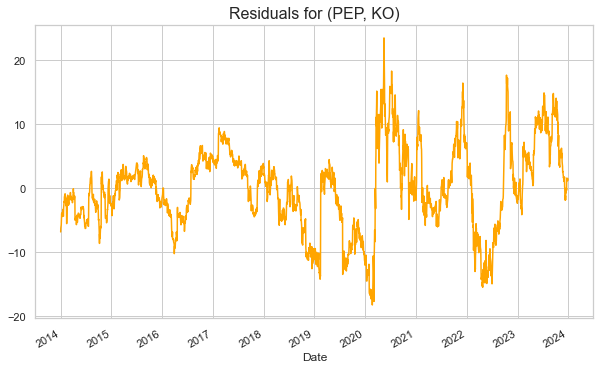

In [10]:
results_list = []
residuals = {}

for col1, col2 in itertools.combinations(list(df.columns)[:3], 2):
    X = df[col1]
    y = df[col2]
    result, residual = engle_granger_coint_test(X, y)
    results_list.append(result)
    residuals[(col1, col2)] = residual

In [11]:
results_df = pd.concat(results_list)
results_df

,ADF Statistic,p-value,Test Result
"(KO, COST)",-3.557189,0.000382,Stationary
"(PEP, COST)",-2.673493,0.007555,Stationary
"(PEP, KO)",-4.333438,0.000015,Stationary


From the table provided, we observe that each pair of stocks—**(KO, COST), (PEP, COST), and (PEP, KO)—exhibits a cointegration relationship**. This is evidenced by the Augmented Dickey-Fuller (ADF) test results, which show all pairs to be stationary. These results strongly suggest that each stock pair moves together in the long term, indicating a stable and significant cointegration relationship between them.

**Step 2**  
Having confirmed a cointegrating relationship in step one, this phase focuses on how these variables adjust in the short term to maintain their long-term equilibrium. It employs an **Error Correction Model (ECM)** to capture these dynamics, linking short-term changes in one variable to those in the other, while also considering the lagged error term from the long-term relationship. This step is crucial for understanding the speed and direction of adjustments that occur when the variables deviate from their established long-term equilibrium.

$$\text{Error Correction Model(ECM)}$$

\begin{align*}
\Delta P^A_t &= \phi \Delta P^B_t - (1 - \alpha)\hat{e}_{t-1} \\
\Delta P^A_t &= \phi \Delta P^B_t - (1 - \alpha) \left( P^A_{t-1} - \beta_c P^B_{t-1} - \mu_e \right)
\end{align*}


In [12]:
def ecm(X, y):
    """Perform the Error Correction Model."""
    dx = X.diff().dropna()
    dy = y.diff().dropna()
    # Step 1: obtain the residual
    x_name = X.name if isinstance(X, pd.Series) else 'X'
    y_name = y.name if isinstance(y, pd.Series) else 'y'
    pair_name = f'({y_name}, {x_name})'
    X = sm.add_constant(X)
    lm = sm.OLS(y, X).fit()
    res = lm.resid
    # Step 2: regress the delta y on delta x and residual
    dx = sm.add_constant(dx)
    dx['e_t_lag1'] = res.shift(1).dropna()
    lm1 = sm.OLS(dy, dx).fit()
    # Step 3: confirm the significance of coefficient of lagged residual
    p_value = lm1.pvalues['e_t_lag1']
    test_result = 'Significant' if p_value < 0.05 else 'Not Significant'
    results_df = pd.DataFrame({
        'p-value': p_value,
        'Test Result': test_result
    }, index=[pair_name])
    return results_df

In [13]:
ecm_results = []
for col1, col2 in itertools.permutations(list(df.columns)[:3], 2):
    X = df[col1]
    y = df[col2]
    result = ecm(X, y)
    ecm_results.append(result)

ecm_results_df = pd.concat(ecm_results)
ecm_results_df

,p-value,Test Result
"(KO, COST)",0.000188,Significant
"(PEP, COST)",0.001778,Significant
"(COST, KO)",0.960948,Not Significant
"(PEP, KO)",0.001751,Significant
"(COST, PEP)",0.337456,Not Significant
"(KO, PEP)",0.000009,Significant


In our analysis using the Error Correction Model (ECM), **the KO (Coca-Cola Co) and PEP (PepsiCo) pair** demonstrated the most significant potential for maintaining long-term equilibrium, with **the lowest p-value of 0.000009**. This strong statistical significance indicates a robust short-term adjustment mechanism, ensuring the pair's return to long-term balance. Therefore, based on the ECM results, **we have selected the KO and PEP pair for our trading strategy**, expecting effective short-term adjustments and stable long-term relationships.

## Signal Generation and Parameter Estimation using Ornstein-Uhlenbeck(OU) Process

After applying the Engle-Granger procedure to establish a long-term relationship between time series variables, the focus shifts to **generating trading signals** and **parameter estimation using the Ornstein-Uhlenbeck (OU) process**, a key step in pairs trading strategies. This approach hinges on identifying deviations from the established equilibrium and making trading decisions accordingly.

The **entry signal** is determined when the current value **deviates significantly from the long-term mean**, suggesting an opportunity to trade on the expectation of reversion to this mean. Conversely, the **exit signal** is generated when values **revert close to the mean**, indicating a time to close positions. The positions themselves involve taking opposing stances on the paired assets based on their deviation from the mean.

Parameter estimation is crucial for the accuracy of these signals. It involves fitting the data to an OU process, which models the **mean-reverting** behavior of the residuals. This process helps in quantifying the extent and **speed of reversion**, providing a more robust basis for signal generation. By leveraging these insights, traders can systematically exploit temporary mispricings, balancing short-term fluctuations with the long-term equilibrium relationship between the assets.

**Entry Signal**

$e_t \gg \mu_e \Rightarrow \mu_e + Z \times \sigma_{eq}$

$e_t \ll \mu_e \Rightarrow \mu_e - Z \times \sigma_{eq}$

**Exit Signal**

$e_t \approx \mu_e$

**Entry Position**

$\mu_e + Z \times \sigma_{eq} \Rightarrow -100\% P_A,  + \beta_{coint}\%P_B$

$\mu_e - Z \times \sigma_{eq} \Rightarrow +100\% P_A,  - \beta_{coint}\%P_B$

To determine the value of $\sigma_{eq}$, it is necessary to fit the data to an Ornstein-Uhlenbeck (OU) process.

The SDE of OU Process is given by:
$$de_t = -\theta(e_t - \mu_e)dt + \sigma dX_t$$

To solve this SDE, we use an integrating factor $e^{\theta t}$, which when applied to both sides of the equation, allows us to transform it into an exact differential.

Multiplying both sides by the integrating factor:
\begin{equation}
e^{\theta t}de_t + \theta e^{\theta t}(e_t - \mu_e)dt = \sigma e^{\theta t}dX_t \tag{1}
\end{equation}
which simplifies to:
\begin{equation}
d(e^{\theta t}e_t) = \theta e^{\theta t}\mu_e dt + \sigma e^{\theta t}dX_t \tag{2}
\end{equation}

We integrate both sides from $t$ to $t+\tau$:
\begin{equation}
e^{\theta (t+\tau)} e_{t+\tau} - e^{\theta t} e_t = - \theta \mu_e \int_{t}^{t+\tau} e^{\theta s} ds + \sigma \int_{t}^{t+\tau} e^{\theta s} dW_s \tag{3}
\end{equation}

After integration, we obtain:
\begin{equation}
e^{\theta (t+\tau)} e_{t+\tau} - e^{\theta t} e_t = \mu_e (e^{\theta (t+\tau)} - e^{\theta t}) + \sigma \int_{t}^{t+\tau} e^{\theta s} dW_s \tag{4}
\end{equation}

Isolating $e_{t+\tau}$:

\begin{equation}
e_{t+\tau} = e^{-\theta \tau} e_t + \mu_e (1 - e^{-\theta \tau}) + \sigma e^{-\theta (t+\tau)} \int_{t}^{t+\tau} e^{\theta s} dW_s \tag{5}
\end{equation}

The stochastic integral: $\sigma e^{-\theta (t+\tau)} \int_{t}^{t+\tau} e^{\theta s} dW_s $ is normally distributed with mean 0 and variance: $$\text{Var}\left( \int_{t}^{t+\tau} e^{\theta s} dW_s \right) = \int_{t}^{t+\tau} e^{2\theta s} ds = \frac{e^{2\theta (t+\tau)} - e^{2\theta t}}{2\theta} $$

Given this, we define the random variable $\epsilon$ representing the noise in the OU process at time $t$: 
$$\epsilon = \sigma e^{-\theta (t+\tau)} \sqrt{\frac{e^{2\theta (t+\tau)} - e^{2\theta t}}{2\theta}} Z $$
where $Z$ is a standard normal random variable.

Therefore, the **solution of this SDE** is 

\begin{equation}
e_{t+\tau} = (1 - e^{-\theta \tau}) \mu_e + e^{-\theta \tau} e_t + \epsilon \tag{6}
\end{equation}

This SDE solution offers two term reversive and autoregressive. Let $C = (1 - e^{-\theta \tau}) \mu $ and $B = e^{-\theta \tau}$, then the formula becomes $e_{t+\tau} = C + B e_t + \epsilon$. I want to use the previous one lag to do the prediction, this become an AR(1) Regression. Let $\tau=1$, and we want to run the $e_{t} = C + B e_{t-1} + \epsilon$. 

In addition, $\sigma_{eq}$ is given by

\begin{equation}
\sigma_{eq} = \sqrt{\frac{SSE \times \tau / T}{1 - e^{-2\theta\tau}}} \tag{7}
\end{equation}

where $\sigma_{eq}$ represents the equilibrium standard deviation, $SSE$ is the sum of squared errors of AR(1) regression of $e_{t}$, $\tau$ is a time increment, and $\theta$ is a rate parameter that dictates the temporal decay rate estimated from AR(1) Regression. This standard deviation is crucial for understanding the dispersion of a stochastic process around its mean level over time. The equation is particularly useful in time series analysis for models that incorporate both error terms and autoregressive properties, providing a statistical measure of variability that is adjusted for autocorrelation.

In [14]:
def ou_process(e):
    """Obtain key parameters estimated from Ornstein-Uhlenbeck SDE solution"""
    tau = 1
    T = 252
    if isinstance(e, np.ndarray):
        e = pd.Series(e)
    e_lag = e.shift(1)
    e_df = pd.concat([e, e_lag], axis=1).dropna()
    e_df.columns = ['e_t', 'e_t_lag1']
    X = sm.add_constant(e_df['e_t_lag1'])
    y = e_df['e_t']
    lm = sm.OLS(y, X).fit()
    B = lm.params['e_t_lag1']
    C = lm.params['const']
    theta = -np.log(B)/tau
    mu_e = C/(tau-B)
    sse = lm.ssr
    sigma_eq = np.sqrt((sse * tau / T) / (1-np.exp(-2*theta*tau)))
    return mu_e, sigma_eq

In [15]:
X = df['PEP']
y = df['KO']
X = sm.add_constant(X)
lm = sm.OLS(y, X).fit()
residual = lm.resid
mu_e, sigma_eq = ou_process(residual)
print('Parameter Estimates from OU Process')
print(f'mu_e: {mu_e}, sigma_eq: {sigma_eq}')

Parameter Estimates from OU Process
mu_e: -0.03371507673266913, sigma_eq: 5.9054306776653105


## Systematic Backtesting

### Train-test Split
We will test the strategy using stock data from 2014 to 2024. We split the data into two segments: training (2014-2018) for model parameter estimation, and testing (2019-2024) for performance evaluation using [Backtrader](https://github.com/mementum/backtrader) and [PyFolio](https://github.com/quantopian/pyfolio). This approach allows us to understand how our strategy performs out-of-sample under different market conditions, providing insights into its practical effectiveness.

In [16]:
in_sample = df[:'2018']
out_sample = df['2019':]
X = in_sample['PEP']
y = in_sample['KO']
X = sm.add_constant(X)
lm = sm.OLS(y, X).fit()
residual = lm.resid
alpha_e_is = lm.params['const']
# is = In-Sample, os = Out-Sample
coint_is = lm.params['PEP']
mu_e_is, sigma_eq_is = ou_process(residual)
print('Parameter Estimates from OU Process In-Sample')
print(f'mu_e: {mu_e_is}, sigma_eq: {sigma_eq_is}')

Parameter Estimates from OU Process In-Sample
mu_e: 0.08308311288176046, sigma_eq: 2.8899488916694733


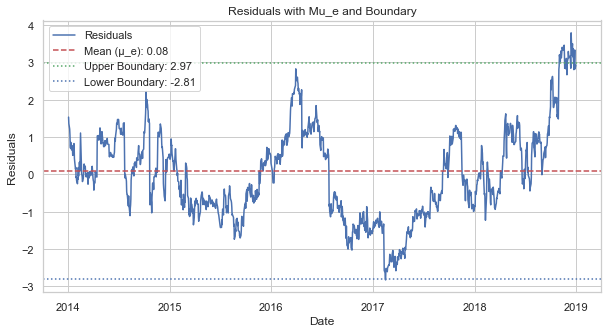

In [17]:
# Test the optimal Z value for the boundary during in-sample period, i.e. Z = 1
Z = 1
upper_bound = mu_e_is + Z * sigma_eq_is
lower_bound = mu_e_is - Z * sigma_eq_is

plt.figure(figsize=(10, 5))
plt.plot(residual, label='Residuals')
plt.axhline(mu_e_is, color='r', linestyle='--', label=f'Mean (μ_e): {mu_e_is:.2f}')
plt.axhline(upper_bound, color='g', linestyle=':', label=f'Upper Boundary: {upper_bound:.2f}')
plt.axhline(lower_bound, color='b', linestyle=':', label=f'Lower Boundary: {lower_bound:.2f}')

plt.title('Residuals with Mu_e and Boundary')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

Observing the plot, it becomes apparent that the residual rarely breaches the established upper and lower boundaries. This suggests the necessity of experimenting with a smaller Z-value, ideally one that is less than 1, to achieve a more sensitive boundary setting.

### In-Sample Backtest

In [18]:
class InSampleBacktest(bt.Strategy):
    params = (('stock1', None), ('stock2', None), ('mu_e', None), ('sigma_eq', None), ('coint', None), ('alpha_e', None), ('Z', None))
    def __init__(self):
        self.buy_flag = 0
        # self.res_df = pd.DataFrame(columns=['residuals'])
        # self.stock_df = pd.DataFrame(columns=['stock1', 'stock2'])
        # print('Start Portfolio Value: %.2f' % self.broker.getvalue())
        # print(self.params.stock1, self.params.stock2, self.params.mu_e, self.params.sigma_eq, self.params.coint, self.params.alpha_e, self.params.Z)
    def next(self):
        # datas[0] = KO (y), datas[1] = PEP (x)
        # e_t = P^A_t - \coint*P^B_t - mu_e
        residual = self.datas[0].close[0] - self.params.coint*self.datas[1].close[0] - self.params.alpha_e
        # with warnings.catch_warnings():
        #     warnings.filterwarnings("ignore", category=FutureWarning)
        #     self.res_df = self.res_df.append({'residuals':residual}, ignore_index=True)
        #     self.stock_df = self.stock_df.append({'stock1':self.datas[0].close[0], 'stock2':self.datas[1].close[0]}, ignore_index=True)
        # Buy/Sell Signal
        if self.buy_flag == 0 and residual > self.params.mu_e + self.params.Z*self.params.sigma_eq:
            self.order_target_percent(self.params.stock1, target=-1)
            self.order_target_percent(self.params.stock2, target=self.params.coint)
            self.buy_flag = 1
        if self.buy_flag == 0 and residual < self.params.mu_e - self.params.Z*self.params.sigma_eq:
            self.order_target_percent(self.params.stock1, target=1)
            self.order_target_percent(self.params.stock2, target=-self.params.coint)
            self.buy_flag = 2
        # Exit Signal
        if self.buy_flag == 1 and residual < self.params.mu_e:
            self.order_target_percent(self.params.stock1, target=0)
            self.order_target_percent(self.params.stock2, target=0)
            self.buy_flag = 0
        if self.buy_flag == 2 and residual > self.params.mu_e:
            self.order_target_percent(self.params.stock1, target=0)
            self.order_target_percent(self.params.stock2, target=0)
            self.buy_flag = 0
        
    def stop(self):
        # print('Final Portfolio Value: %.2f' % self.broker.getvalue())
        pass

def load_data(stockname, start, end):
    data = yf.download(stockname, start=start, end=end, progress=False)
    # Adjust Open, High, Low prices based on Adj Close
    adj_ratio = data['Adj Close'] / data['Close']
    data['Open'] = data['Open'] * adj_ratio
    data['High'] = data['High'] * adj_ratio
    data['Low'] = data['Low'] * adj_ratio
    # Replace 'Close' with 'Adj Close'
    data['Close'] = data['Adj Close']
    # print('stockname:', stockname)
    # print(data.head())
    data_bt = bt.feeds.PandasData(dataname=data)
    return data_bt

def run_backtest(stock1, stock2, start, end, mu_e_is, sigma_eq_is, coint_is, alpha_is, Z_is):
    cerebro = bt.Cerebro()
    for instrument in [stock1, stock2]:
        bt_data = load_data(instrument, start, end)
        cerebro.adddata(bt_data, name=instrument)

    cerebro.addstrategy(InSampleBacktest, stock1=stock1, stock2=stock2, mu_e = mu_e_is, sigma_eq = sigma_eq_is, coint=coint_is, alpha_e = alpha_is, Z = Z_is)
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='trades')
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

    results = cerebro.run()
    first_result = results[0]
    # cerebro.plot(width=30, height=20)
    return first_result


in_sample_start = '2014-01-01'
in_sample_end = '2018-12-31'
# Z_is = 0.3
# result_is = run_backtest('KO', 'PEP', in_sample_start, in_sample_end, mu_e_is, sigma_eq_is, coint_is, alpha_e_is, Z_is)

Z_values = np.arange(0.1, 1.05, 0.05)
best_sharpe = float('-inf')
best_Z = None
best_result_is = None
bt_results = []

for Z in Z_values:
    bt_result = run_backtest('KO', 'PEP', in_sample_start, in_sample_end, mu_e_is, sigma_eq_is, coint_is, alpha_e_is, Z)
    sharpe_ratio = bt_result.analyzers.sharpe.get_analysis()['sharperatio']
    tot_returns = bt_result.analyzers.returns.get_analysis()['rtot']
    bt_results.append({'Z': Z, 'Sharpe Ratio': sharpe_ratio, 'Total Returns': tot_returns})
    # print(f"Z: {Z}, Sharpe Ratio: {sharpe_ratio}, Total Returns: {tot_returns}")
    if sharpe_ratio > best_sharpe:
        best_sharpe = sharpe_ratio
        best_Z = Z
        best_result_is = bt_result

bt_results_df = pd.DataFrame(bt_results)
print('In Sample Backtest Results')
print(bt_results_df)
print(f"Best Z: {best_Z:.2f} with Sharpe Ratio: {best_sharpe:.3f}")

In Sample Backtest Results
       Z  Sharpe Ratio  Total Returns
0   0.10      0.741711       0.352877
1   0.15      1.050065       0.434506
2   0.20      1.397132       0.479755
3   0.25      0.536036       0.290253
4   0.30      1.003451       0.426070
5   0.35      0.923646       0.439075
6   0.40      0.593339       0.333797
7   0.45      0.525180       0.232610
8   0.50      0.236822       0.116290
9   0.55      0.474668       0.177584
10  0.60      0.513504       0.185238
11  0.65      0.208677       0.093859
12  0.70      0.249445       0.105762
13  0.75     -0.220591       0.012121
14  0.80     -0.073666       0.031306
15  0.85     -0.075433       0.030927
16  0.90      0.037113       0.053291
17  0.95      0.336847       0.133024
18  1.00     -1.143128      -0.020439
Best Z: 0.20 with Sharpe Ratio: 1.397


From the backtest results, we can see that the optimal Z value is 0.2 with the highest Sharpe Ratio of 1.397. The total returns are 0.48. 

In [19]:
# Benchmark Strategy Backtest - Buy and Hold
class BenchmarkStrategy(bt.Strategy):
    params = (('benchmark', None), ('amount', 10000),)
    def __init__(self):
        self.benchmark = self.params.benchmark
        self.amount = self.params.amount
        self.has_bought = False
    def nextstart(self):
        # self.order_target_percent(self.benchmark, target=1)
        size = int(self.amount / self.datas[0].close[0])
        self.buy(data = self.datas[0], size=size)
        self.has_bought = True
    def next(self):
        # self.order_target_percent(self.benchmark, target=1)
        pass

def benchmark_backtest(benchmark, start, end):
    cerebro = bt.Cerebro()
    bt_data = load_data(benchmark, start, end)
    cerebro.adddata(bt_data, name=benchmark)
    cerebro.addstrategy(BenchmarkStrategy, benchmark=benchmark)
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='trades')
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    results = cerebro.run()
    return results[0]

benchmark_is = benchmark_backtest('XLP', in_sample_start, in_sample_end)

### In-Sample Backtest Results Analysis

In [20]:
def bt_result_analysis(result, trade_analysis = True, pyfolio_tear_sheet=False, benchmark_result = None):
    # Extract Sharpe Ratio
    sharpe_ratio = result.analyzers.sharpe.get_analysis()['sharperatio']
    tot_return = result.analyzers.returns.get_analysis()['rtot']
    annualized_return = result.analyzers.returns.get_analysis()['rnorm100']

    return_table = PrettyTable()
    return_table.field_names = ["Metric", "Value"]
    return_table.add_rows([
        ["Sharpe Ratio", f"{sharpe_ratio:.3f}"],
        ["Total Return", f"{tot_return*100:.2f}%"],
        ["Annualized Return", f"{annualized_return:.2f}%"]
    ])
    if benchmark_result is not None:
        benchmark_sharpe_ratio = benchmark_result.analyzers.sharpe.get_analysis()['sharperatio']
        benchmark_tot_return = benchmark_result.analyzers.returns.get_analysis()['rtot']
        benchmark_annualized_return = benchmark_result.analyzers.returns.get_analysis()['rnorm100']
        return_table.add_rows([
            ["Benchmark Sharpe Ratio", f"{benchmark_sharpe_ratio:.3f}"],
            ["Benchmark Total Return", f"{benchmark_tot_return*100:.2f}%"],
            ["Benchmark Annualized Return", f"{benchmark_annualized_return:.2f}%"]
        ])
    print("\nReturns:\n", return_table)

    # Extract Drawdown Info
    drawdown_info = result.analyzers.drawdown.get_analysis()
    longest_drawdown_length = drawdown_info['max']['len']
    max_percentage_drawdown = drawdown_info['max']['drawdown']
    max_monetary_drawdown = drawdown_info['max']['moneydown']

    drawdown_summary_table = PrettyTable()
    drawdown_summary_table.field_names = ["Metric", "Value"]
    drawdown_summary_table.add_rows([
        ["Longest Drawdown Length", longest_drawdown_length],
        ["Max Percentage Drawdown", f"{max_percentage_drawdown:.2f}%"],
        ["Max Monetary Drawdown", f"{max_monetary_drawdown:.2f}"]
    ])
    print("\nDrawdown Info:\n", drawdown_summary_table)

    # Extract Trade Analysis Results
    if trade_analysis:
        trade_analysis = result.analyzers.trades.get_analysis()
        total_trades = trade_analysis['total']['closed']
        total_wins = trade_analysis['won']['total']
        total_losses = trade_analysis['lost']['total']
        win_ratio = total_wins / total_trades if total_trades > 0 else 0

        average_win = trade_analysis['won']['pnl']['average']
        average_loss = trade_analysis['lost']['pnl']['average']
        max_win = trade_analysis['won']['pnl']['max']
        max_loss = trade_analysis['lost']['pnl']['max']

        trade_summary_table = PrettyTable()
        trade_summary_table.field_names = ["Metric", "Value"]
        trade_summary_table.add_rows([
            ["Total Trades", total_trades],
            ["Total Wins", total_wins],
            ["Total Losses", total_losses],
            ["Win Ratio", f"{win_ratio:.2%}"],
            ["Average Win PnL", f"{average_win:.2f}"],
            ["Average Loss PnL", f"{average_loss:.2f}"],
            ["Max Win PnL", f"{max_win:.2f}"],
            ["Max Loss PnL", f"{max_loss:.2f}"]
        ])
        print("\nTrade Analysis:\n", trade_summary_table)

    # Get PyFolio analysis
    if pyfolio_tear_sheet:
        pyfolio_analyzer = result.analyzers.getbyname('pyfolio')
        returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()
        if benchmark_result is not None:
            bm_pyfolio_analyzer = benchmark_result.analyzers.getbyname('pyfolio')
            bm_returns, _, _, _ = bm_pyfolio_analyzer.get_pf_items()
            bm_returns.name = 'benchmark'
        # In order to obtain PyFolio Tear sheet, we need to fix issue in Pyfolio package
        # Modify timeseries.py line 893: valley = underwater.index[np.argmin(underwater)] # end of the period
        # See https://stackoverflow.com/questions/63554616/attributeerror-numpy-int64-object-has-no-attribute-to-pydatetime
            pf.create_full_tear_sheet(returns, transactions=transactions, benchmark_rets=bm_returns)
        else:
            pf.create_full_tear_sheet(returns, transactions=transactions)

In [21]:
bt_result_analysis(best_result_is, trade_analysis=True, pyfolio_tear_sheet=False, benchmark_result=benchmark_is)


Returns:
 +-----------------------------+--------+
|            Metric           | Value  |
+-----------------------------+--------+
|         Sharpe Ratio        | 1.397  |
|         Total Return        | 47.98% |
|      Annualized Return      | 10.10% |
|    Benchmark Sharpe Ratio   | 0.652  |
|    Benchmark Total Return   | 30.51% |
| Benchmark Annualized Return | 6.31%  |
+-----------------------------+--------+

Drawdown Info:
 +-------------------------+---------+
|          Metric         |  Value  |
+-------------------------+---------+
| Longest Drawdown Length |   250   |
| Max Percentage Drawdown |  9.39%  |
|  Max Monetary Drawdown  | 1595.57 |
+-------------------------+---------+

Trade Analysis:
 +------------------+---------+
|      Metric      |  Value  |
+------------------+---------+
|   Total Trades   |    42   |
|    Total Wins    |    24   |
|   Total Losses   |    18   |
|    Win Ratio     |  57.14% |
| Average Win PnL  |  388.26 |
| Average Loss PnL | -133.82 |

The returns table clearly indicates that the strategy **outperforms the benchmark** during the **in-sample period**. The Sharpe Ratio for the strategy is significantly higher at 1.397 compared to the benchmark's 0.652. Additionally, the strategy achieved a higher Cumulative Return of 47.98% compared to the benchmark's 30.51%. These results demonstrate the solid performance of the pairs strategy.

In [22]:
def load_data_df(stockname, start, end):
    data = yf.download(stockname, start=start, end=end, progress=False)
    # Adjust Open, High, Low prices based on Adj Close
    adj_ratio = data['Adj Close'] / data['Close']
    data['Open'] = data['Open'] * adj_ratio
    data['High'] = data['High'] * adj_ratio
    data['Low'] = data['Low'] * adj_ratio
    # Replace 'Close' with 'Adj Close'
    data['Close'] = data['Adj Close']
    return data

### Out of Sample Backtest
For the out-of-sample backtest, I specifically use in-sample data along with the latest out-of-sample data to dynamically estimate parameters including mu_e, sigma_eq, and cointegration (coint). This method **avoids look-ahead bias** and also maximizes the utility of the data. By running Ordinary Least Squares (OLS) on this comprehensive dataset, the parameter estimation becomes more accurate.

<IPython.core.display.Javascript object>

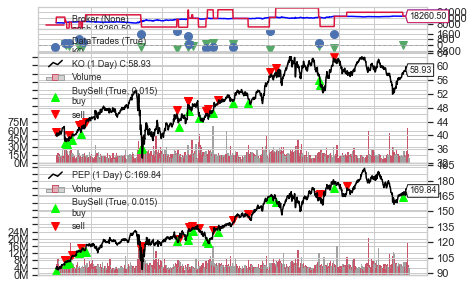

In [23]:
class OutSampleBacktest(bt.Strategy):
    params = (('stock1', None), ('stock2', None), ('mu_e', None), ('sigma_eq', None), ('coint', None), ('alpha_e', None), ('Z', None), ('data_stock1_is', None), ('data_stock2_is', None),)
    def __init__(self):
        self.buy_flag = 0
        # print('Start Portfolio Value: %.2f' % self.broker.getvalue())
        self.in_sample_data = {
            'stock1': self.params.data_stock1_is,
            'stock2': self.params.data_stock2_is
        }
        self.last_ols_update = None
        self.price_history = {'stock1': pd.Series(dtype='float'), 'stock2': pd.Series(dtype='float')}
        # print(self.params.stock1, self.params.stock2, self.params.mu_e, self.params.sigma_eq, self.params.coint, self.params.alpha_e, self.params.Z)
    def next(self):
        # datas[0] = KO (y), datas[1] = PEP (x)
        # e_t = P^A_t - \coint*P^B_t - mu_e

        current_date_stock1 = self.datas[0].datetime.date(0)
        current_date_stock2 = self.datas[1].datetime.date(0)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            self.price_history['stock1'] = self.price_history['stock1'].append(pd.Series([self.datas[0].close[0]], index=[current_date_stock1]))
            self.price_history['stock2'] = self.price_history['stock2'].append(pd.Series([self.datas[1].close[0]], index=[current_date_stock2]))
        if self.last_ols_update is None or self.days_since_last_update() >= 22*3:  # Update parameters on the fly every 3 month
            self.update_ols_parameters()
            self.last_ols_update = self.datetime.date(0)

        residual = self.datas[0].close[0] - self.params.coint*self.datas[1].close[0] - self.params.alpha_e
        # Buy/Sell Signal
        if self.buy_flag == 0 and residual > self.params.mu_e + self.params.Z*self.params.sigma_eq:
            self.order_target_percent(self.params.stock1, target=-1)
            self.order_target_percent(self.params.stock2, target=self.params.coint)
            self.buy_flag = 1
        if self.buy_flag == 0 and residual < self.params.mu_e - self.params.Z*self.params.sigma_eq:
            self.order_target_percent(self.params.stock1, target=1)
            self.order_target_percent(self.params.stock2, target=-self.params.coint)
            self.buy_flag = 2
        # Exit Signal
        if self.buy_flag == 1 and residual < self.params.mu_e:
            self.order_target_percent(self.params.stock1, target=0)
            self.order_target_percent(self.params.stock2, target=0)
            self.buy_flag = 0
        if self.buy_flag == 2 and residual > self.params.mu_e:
            self.order_target_percent(self.params.stock1, target=0)
            self.order_target_percent(self.params.stock2, target=0)
            self.buy_flag = 0
        
    def stop(self):
        # print('Final Portfolio Value: %.2f' % self.broker.getvalue())
        pass

    def days_since_last_update(self):
        return (self.datetime.date(0) - self.last_ols_update).days
    
    def update_ols_parameters(self):
        combined_data_stock1 = pd.concat([self.in_sample_data['stock1']['Close'], self.price_history['stock1']])
        combined_data_stock2 = pd.concat([self.in_sample_data['stock2']['Close'], self.price_history['stock2']])

        # Perform OLS regression
        Y = np.array(combined_data_stock1)
        X = np.array(combined_data_stock2)
        X = sm.add_constant(X)
        lm = sm.OLS(Y, X).fit()
        residuals = lm.resid
        self.params.mu_e, self.params.sigma_eq = ou_process(residuals)
        self.params.coint = lm.params[1]
        self.params.alpha_e = lm.params[0]

def run_backtest(stock1, stock2, start, end, mu_e_is, sigma_eq_is, coint_is, alpha_is, Z_is, in_sample_start, in_sample_end):
    cerebro = bt.Cerebro()
    # Load In-Sample Data
    data_stock1_is = load_data_df(stock1, in_sample_start, in_sample_end)
    data_stock2_is = load_data_df(stock2, in_sample_start, in_sample_end)
    # Load Out-Sample Data
    for instrument in [stock1, stock2]:
        bt_data = load_data(instrument, start, end)
        cerebro.adddata(bt_data, name=instrument)

    cerebro.addstrategy(OutSampleBacktest, stock1=stock1, stock2=stock2, mu_e = mu_e_is, sigma_eq = sigma_eq_is, coint=coint_is, alpha_e = alpha_is, Z = Z_is, data_stock1_is = data_stock1_is, data_stock2_is = data_stock2_is)
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='trades')
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

    results = cerebro.run()
    first_result = results[0]
    cerebro.plot(width=80, height=50)
    return first_result

os_sample_start = '2019-01-01'
os_sample_end = '2023-12-31'
# Z_os = 0.2
Z_os = best_Z
result_os = run_backtest('KO', 'PEP', os_sample_start, os_sample_end, mu_e_is, sigma_eq_is, coint_is, alpha_e_is, Z_os, in_sample_start, in_sample_end)


Returns:
 +-----------------------------+--------+
|            Metric           | Value  |
+-----------------------------+--------+
|         Sharpe Ratio        | 0.721  |
|         Total Return        | 60.22% |
|      Annualized Return      | 12.82% |
|    Benchmark Sharpe Ratio   | 0.881  |
|    Benchmark Total Return   | 48.65% |
| Benchmark Annualized Return | 10.24% |
+-----------------------------+--------+

Drawdown Info:
 +-------------------------+---------+
|          Metric         |  Value  |
+-------------------------+---------+
| Longest Drawdown Length |   209   |
| Max Percentage Drawdown |  19.29% |
|  Max Monetary Drawdown  | 2276.64 |
+-------------------------+---------+

Trade Analysis:
 +------------------+---------+
|      Metric      |  Value  |
+------------------+---------+
|   Total Trades   |    31   |
|    Total Wins    |    17   |
|   Total Losses   |    14   |
|    Win Ratio     |  54.84% |
| Average Win PnL  |  682.58 |
| Average Loss PnL | -238.81 |

d:\Anaconda3\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
d:\Anaconda3\lib\site-packages\pyfolio\plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2019-01-02
End date,2023-12-29
Total months,59
,Backtest
Annual return,12.8%
Cumulative returns,82.6%
Annual volatility,17.1%
Sharpe ratio,0.79
Calmar ratio,0.66
Stability,0.87
Max drawdown,-19.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.29,2019-05-16,2020-02-21,2020-03-12,216
1,12.01,2020-04-09,2020-05-15,2020-06-05,42
2,11.59,2020-03-18,2020-03-23,2020-04-06,14
3,11.00,2020-06-08,2020-07-09,2020-09-02,63
4,10.61,2022-03-10,2022-04-21,2022-11-11,177


<IPython.core.display.Javascript object>

d:\Anaconda3\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
d:\Anaconda3\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
d:\Anaconda3\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
d:\Anaconda3\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=retu

Stress Events,mean,min,max
New Normal,0.05%,-6.35%,9.99%


d:\Anaconda3\lib\site-packages\pyfolio\timeseries.py:1228: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


<IPython.core.display.Javascript object>

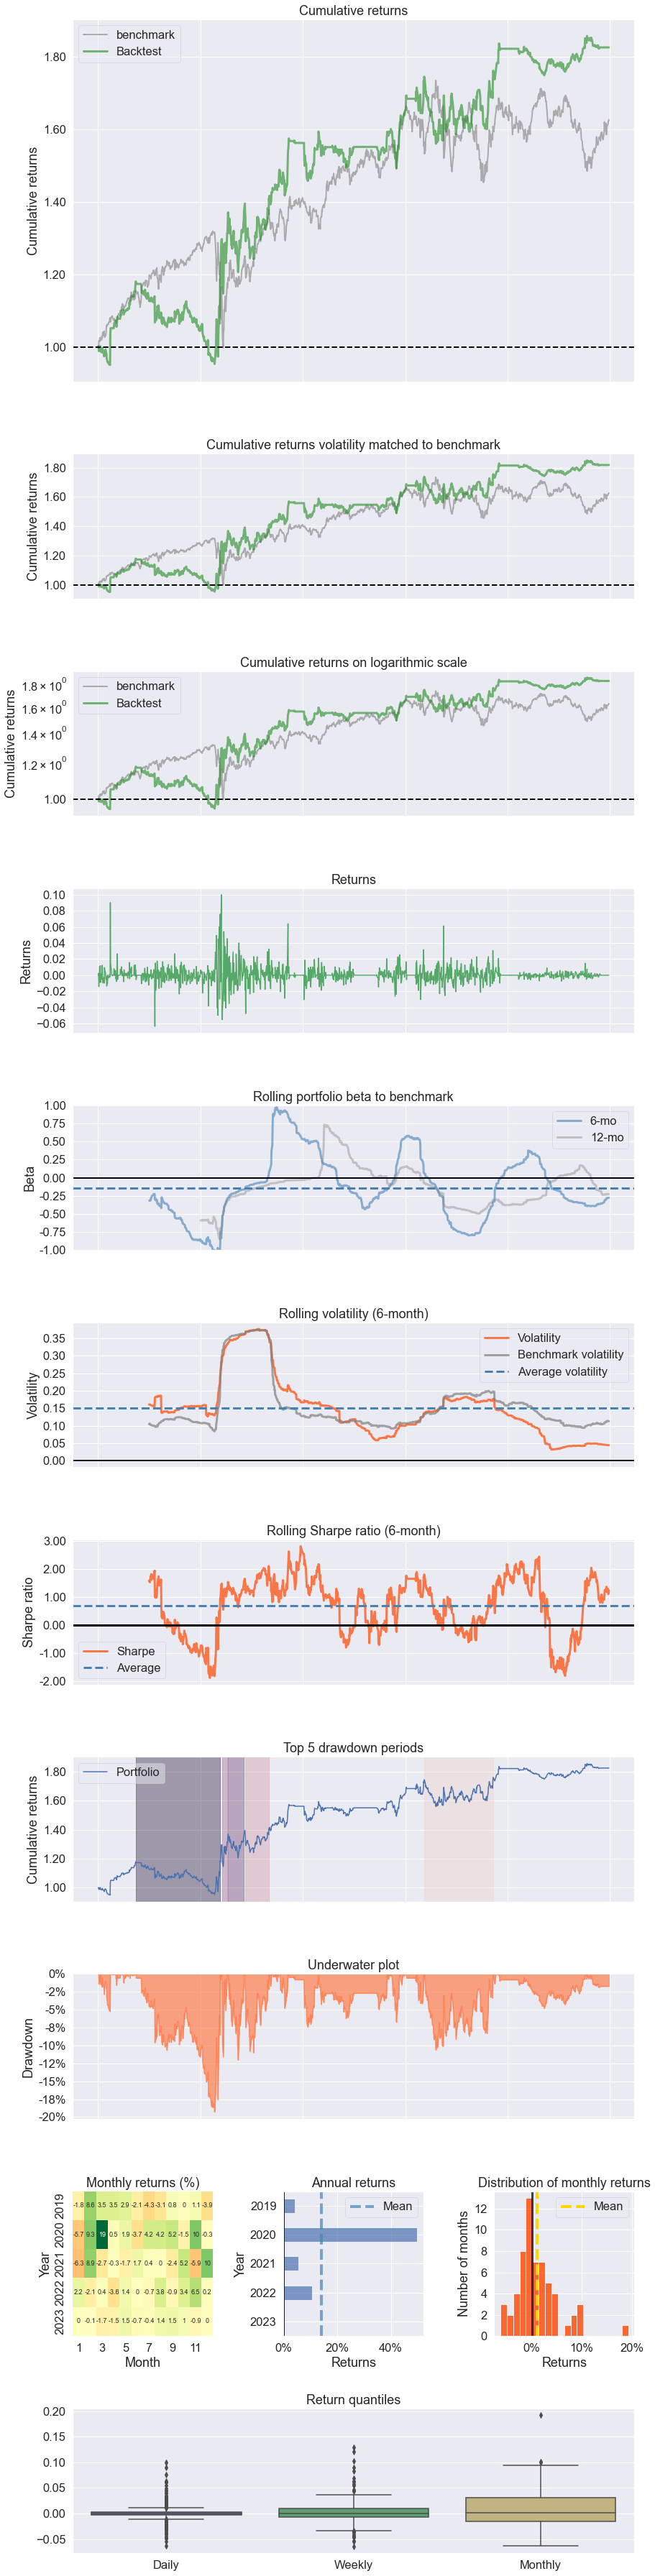

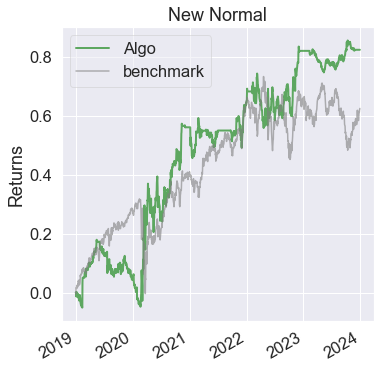

In [24]:
benchmark_os = benchmark_backtest('XLP', os_sample_start, os_sample_end)
bt_result_analysis(result_os, trade_analysis=True, pyfolio_tear_sheet=True, benchmark_result=benchmark_os)

### Out of Sample Backtest Results Analysis

The results from our out-of-sample backtesting reveal some critical insights into the pairs trading strategy. While this strategy exhibits a lower Sharpe ratio of 0.721 compared to both the in-sample Sharpe ratio of 1.397 and the benchmark Sharpe ratio of 0.881, it demonstrates superior performance in other key areas. Notably, it achieves a higher total return of 60.22% and an annualized return of 12.82%, surpassing the benchmark's total return of 48.65% and annualized return of 10.24%.

However, the strategy's risk profile warrants attention. The drawdown analysis indicates a significant challenge during early 2020, likely due to the COVID-19 market meltdown, with a maximum percentage drawdown of 19.29% and a longest drawdown length of 209 days. These factors, along with the lower Sharpe ratio, signal a **need for enhanced risk management** in the pairs trading strategy.

Despite these concerns, the cumulative return plot suggests a commendable **consistency in returns**, underscoring the strategy's effectiveness as a **market-neutral** approach. By implementing more stringent risk controls, this strategy has the potential to yield even more consistent and robust returns.

### Factor Backtesting

In [25]:
os_returns, os_positions, os_transactions, os_gross_lev = result_os.analyzers.pyfolio.get_pf_items()
os_returns.index = os_returns.index.tz_localize(None)
os_returns.name = 'Pairs Trading Strategy'
sp500_data = yf.download('^GSPC', start=os_sample_start, end=os_sample_end, progress=False)['Adj Close']
sp500_returns = sp500_data.pct_change().fillna(0)
sp500_returns.name = 'S&P 500'

<IPython.core.display.Javascript object>

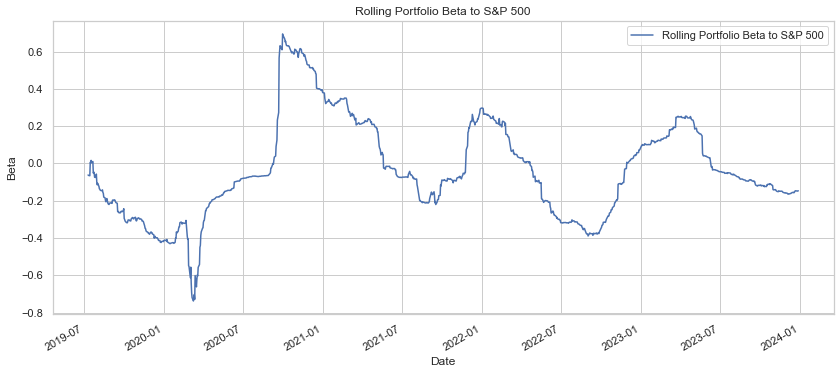

In [26]:
aligned_returns = pd.concat([os_returns, sp500_returns], axis=1).dropna()

window_size = 22*6 # 6 months rolling beta

rolling_covariance = aligned_returns['Pairs Trading Strategy'].rolling(window=window_size).cov(aligned_returns['S&P 500'])
rolling_variance = aligned_returns['S&P 500'].rolling(window=window_size).var()

rolling_beta = rolling_covariance / rolling_variance

plt.figure(figsize=(14, 6))
rolling_beta.plot(label='Rolling Portfolio Beta to S&P 500')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.title('Rolling Portfolio Beta to S&P 500')
plt.legend()
plt.show()

### Rolling Beta Discussion
In strategies like pairs trading, the market exposure (beta) might not be as significant a measure as it is for long-term investments. This is because the strategy often aim for market neutrality and quick profit from short-term inefficiencies, rather than relying on long-term market movements.

The rolling beta plot demonstrates that our portfolio maintains a **relatively low market exposure**, fluctuating between **-0.6 to 0.6**. This range suggests a strategy that is largely **market-neutral**, as it doesn't consistently correlate strongly with the S&P 500's movements. The oscillation of beta values around zero highlights the strategy's active management aimed at capitalizing on short-term inefficiencies rather than following long-term market trends. The fluctuation indicates that while the portfolio occasionally leans slightly towards or against the market, it generally aims to avoid significant market risk, adhering to the principles of statistical arbitrage and market-making.

### Exposure to Fama-French 5 Factor Models
Fama French 5 factors data is obtained from [Kenneth French's website at Dartmouth College](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html)

<IPython.core.display.Javascript object>

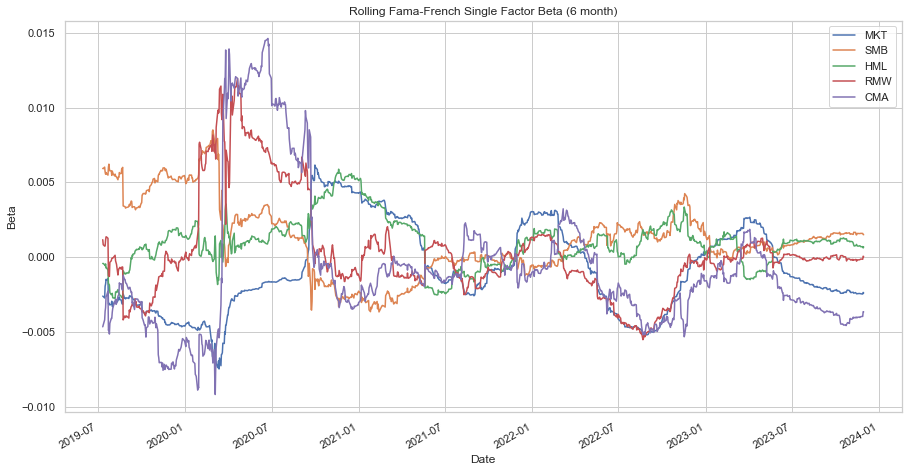

In [27]:
fama_french_data = pd.read_csv('data/F-F_Research_Data_5_Factors_daily.csv', skiprows=3, index_col=0, parse_dates=True)
fama_french_data.index = pd.to_datetime(fama_french_data.index)
ret_ff = pd.merge(os_returns, fama_french_data, left_index=True, right_index=True)

window_size = 22*6 # 6 months rolling

def rolling_factor_betas(data, window):
    betas = pd.DataFrame(index=data.index, columns=['MKT', 'SMB', 'HML', 'RMW', 'CMA'])

    for start in range(len(data) - window + 1):
        end = start + window
        y = data['Pairs Trading Strategy'][start:end]
        X = data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']][start:end]
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        betas.iloc[end - 1] = model.params[1:]

    return betas
rolling_betas = rolling_factor_betas(ret_ff, window_size)
rolling_betas.plot(figsize=(15, 8))
plt.title('Rolling Fama-French Single Factor Beta (6 month)')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

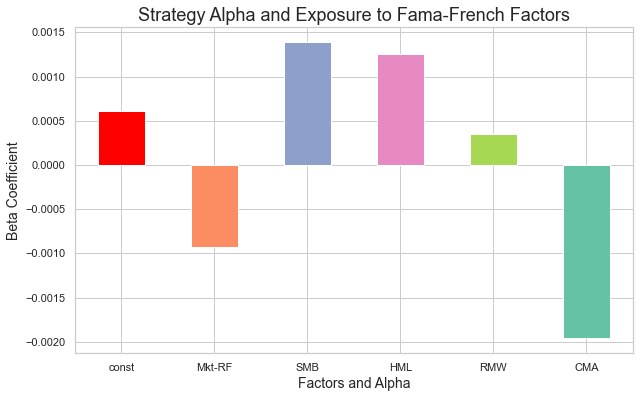

In [35]:
y = ret_ff['Pairs Trading Strategy']
X = ret_ff[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
X = sm.add_constant(X)
lm_ff = sm.OLS(y, X).fit()
betas = lm_ff.params

plt.figure(figsize=(10, 6))
palette = sns.color_palette("Set2", len(betas.drop('const')))
betas.plot(kind='bar', color=palette)

plt.title('Strategy Alpha and Exposure to Fama-French Factors', fontsize=18)
plt.ylabel('Beta Coefficient', fontsize=14)
plt.xlabel('Factors and Alpha', fontsize=14)
plt.xticks(rotation=0)

bars = plt.gca().patches
bars[0].set_facecolor('red')

plt.show()

<IPython.core.display.Javascript object>

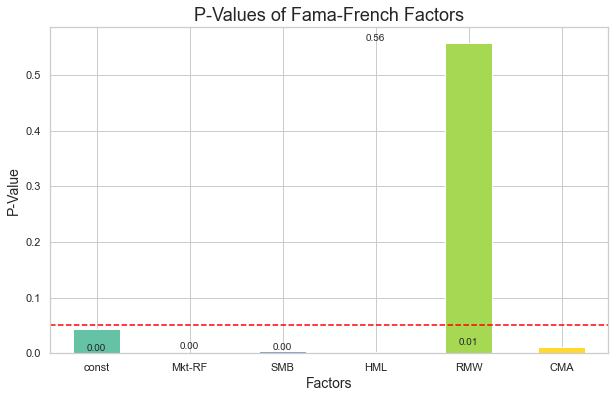

In [29]:
p_values = lm_ff.pvalues
plt.figure(figsize=(10, 6))

p_values.plot(kind='bar', color=sns.color_palette("Set2", len(p_values)))
plt.title('P-Values of Fama-French Factors', fontsize=18)
plt.ylabel('P-Value', fontsize=14)
plt.axhline(y=0.05, color='red', linestyle='--')
plt.xlabel('Factors', fontsize=14)
plt.xticks(rotation=0)

for i, value in enumerate(p_values.drop('const')):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom', fontsize=10)

plt.show()

### Factor Analysis Discussion
Our analysis using the Fama-French five-factor model yields pivotal insights into our Pairs Trading Strategy's performance dynamics. The strategy demonstrates a **statistically significant alpha**, implying an adeptness at generating above-baseline returns as per the model's predictions. The near-zero p-values for the constant term and most factors substantiate their significant contributory roles. Specifically, the strategy is inversely correlated with market risk (Mkt-RF) and the size factor (SMB), while showing a positive association with value (HML) and company profitability (RMW). The strategy's negative beta with respect to the CMA factor indicates a divergence from conservative investment tendencies, though this factor's influence on return is statistically unsubstantial. However, it is crucial to note that, given the **market-neutral nature** of this strategy, the **factor exposures may not fully encapsulate the true alpha**. Market-neutral strategies aim to negate market risk and typically exhibit minimal correlation with market indices, which may lead to a misrepresentation of alpha when analyzed through traditional factor models. This nuance is essential for a holistic understanding of the strategy's performance and its inherent market-neutral objective.